In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('nbagg')
import folium
from tqdm import tqdm
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from ratelimiter import RateLimiter

In [64]:
clinic_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\Project\Patient_Clinic_Proximity\clinics.csv')
print(clinic_df.shape)
clinic_df.head(2)

(100, 7)


,Clinic ID,Clinic Name,Clinic Address,Postal Code,FSA,Clinic City,Province
0,1,Clinic 1,8308 114 St Nw Suite 2020,T6G 2V2,T6G,Edmonton,AB
1,2,Clinic 2,3480 Lawrence Ave E Unit 5,M1H 1A9,M1H,Scarborough,ON


In [16]:
nominatim_service = Nominatim(user_agent="namrata.thakur893@gmail.com")

In [65]:
@RateLimiter(max_calls=10, period=1)
def get_geocode_new(address,post_code,fsa,city,prov):

    location = nominatim_service.geocode(address)
    if location != None:
        return location.latitude, location.longitude
    else:
        post_code_geo = nominatim_service.geocode(post_code)
        if post_code_geo != None:
            return post_code_geo.latitude, post_code_geo.longitude
        else:
            fsa_geo = nominatim_service.geocode(fsa)
            if fsa_geo != None:
                return fsa_geo.latitude, fsa_geo.longitude
            else:
                city_geo = nominatim_service.geocode(city)
                if city_geo != None:
                    return city_geo.latitude, city_geo.longitude
                else:
                    prov_geo = nominatim_service.geocode(prov)
                    if prov_geo != None:
                        return prov_geo.latitude, prov_geo.longitude

In [66]:
clinic_df['Geocode_Feat_Lat'], clinic_df['Geocode_Feat_Long'] = zip(*clinic_df.apply(lambda x: get_geocode_new(x['Clinic Address'], x['Postal Code'], x['FSA'], x['Clinic City'], x['Province']), axis=1))

In [68]:
clinic_df.head(20)

,Clinic ID,Clinic Name,Clinic Address,Postal Code,FSA,Clinic City,Province,Geocode_Feat_Lat,Geocode_Feat_Long
0,1,Clinic 1,8308 114 St Nw Suite 2020,T6G 2V2,T6G,Edmonton,AB,53.522712,-113.523478
1,2,Clinic 2,3480 Lawrence Ave E Unit 5,M1H 1A9,M1H,Scarborough,ON,37.260291,-6.932783
2,3,Clinic 3,4715 8 Ave Se,T2A 3N4,T2A,Calgary,AB,51.044900,-113.967219
3,4,Clinic 4,234 Dovedale Drive,L4P 0H3,L4P,Keswick,ON,43.881407,-78.926401
4,5,Clinic 5,3968 Rue Notre-Dame O Etage 2E,H4C 1R1,H4C,Montreal,QC,45.477898,-73.583652
5,6,Clinic 6,3400 Rue Du Marche Bureau 203,H9B 2Y1,H9B,Dollard-Des-Ormeaux,QC,47.444415,5.590398
6,7,Clinic 7,1441 29 St Nw,T2N 4J8,T2N,Calgary,AB,51.065033,-114.130437
7,8,Clinic 8,910 Rue Labelle,J7Z 5M5,J7Z,Saint-Jerome,QC,45.788776,-74.005892
8,9,Clinic 9,32 Rue De La Reserve,G0T 1K0,G0T,Essipit,QC,48.342951,-69.398543
9,10,Clinic 10,1615 Boul Jacques-Cartier E Bureau 200,J4M 2X1,J4M,Longueuil,QC,45.517238,-73.446747


Some of the Latitude and Longitude values that we got using geopy() are not correct. We are concluding this because all the clinics' locations are in Canada but for some clinics the corresponding Latitude and Longitude values are outside of the country. The error maybe because geopy() is confusing that location with some other. So we have to manually clean those values.

Example : Scarborough (Clinic City for Clinic_ID = 2). Scarborough as a town is present both in Canada (Ontario Province) as well as in North Yorkshire, England.

In [122]:
clinic_df['Geocode_Feat_Long'][1] = '-60.73525'
clinic_df['Geocode_Feat_Long'][5] = '-73.816666'
clinic_df['Geocode_Feat_Long'][16] = '-79.83713'
clinic_df['Geocode_Feat_Lat'][16] = '43.38621'

clinic_df['Geocode_Feat_Long'][24] = '-80.4230'
clinic_df['Geocode_Feat_Long'][31] = '-63.57291'
clinic_df['Geocode_Feat_Long'][52] = '-113.323975'
clinic_df['Geocode_Feat_Long'][64] = '-89.25018'
clinic_df['Geocode_Feat_Long'][77] = '-77.38277'

clinic_df['Geocode_Feat_Long'][89] = '-79.233238'
clinic_df['Geocode_Feat_Long'][95] = '-75.69812'

clinic_df['Geocode_Feat_Long'][99] = '-81.23304'
clinic_df['Geocode_Feat_Lat'][99] = '42.98339'

clinic_df['Geocode_Feat_Long'][94] = '-80.99001'
clinic_df['Geocode_Feat_Lat'][94] = '46.49'

clinic_df['Geocode_Feat_Long'][97] = '-79.766670'

clinic_df['Geocode_Feat_Long'][51] = '-106.647034'
clinic_df['Geocode_Feat_Lat'][51] = '52.146973'

C:\Users\NamrataT\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\NamrataT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\NamrataT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\N

In [220]:
mino = clinic_df['Geocode_Feat_Long'].max()
mino

-60.73525

In [221]:
geocode_df = clinic_df[['Geocode_Feat_Lat','Geocode_Feat_Long']].values
geocode_df.shape

(100, 2)

In [222]:
train_inertia = []
clusters = 10

for i in tqdm(range(1,clusters+1)):
    km = KMeans(n_clusters = i, random_state=0)
    
    km.fit(geocode_df)
    train_inertia.append(km.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.87it/s]


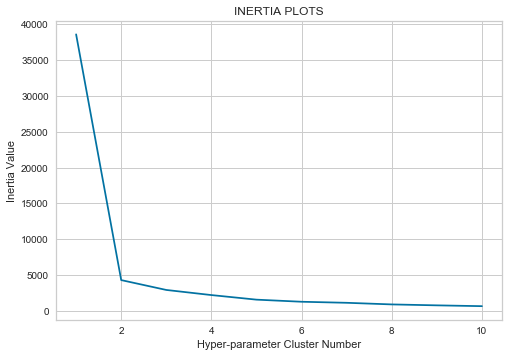

In [223]:
# Plotting Inertia_ against Number of CLusters
plt.plot(range(1,clusters+1),train_inertia)
plt.title("INERTIA PLOTS")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Inertia Value')
plt.show()

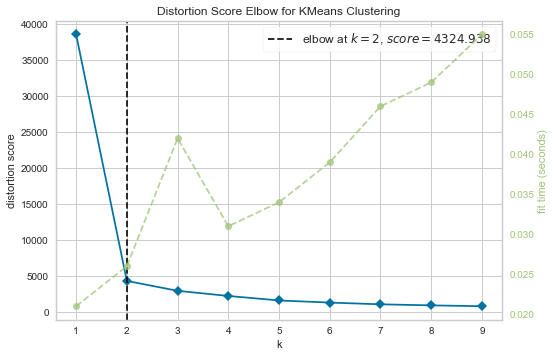

In [224]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True)
visualizer.fit(geocode_df)        # Fit data to visualizer
visualizer.show() 

In [280]:
km_test = KMeans(n_clusters = 2, random_state=0)   
km_test.fit(geocode_df)
print('Best Inertia : ',km_test.inertia_)    
print('Cluster Labels :',km_test.labels_)

Best Inertia :  4324.9377957974575
Cluster Labels : [0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1]


In [281]:
labels = km_test.labels_
clinic_df['Cluster_ID'] = labels

In [283]:
cluster_centers = km_test.cluster_centers_
print('Cluster Centres for 2 clusters : \n',cluster_centers)

Cluster Centres for 2 clusters : 
 [[  50.67612849 -114.49137933]
 [  44.99093047  -77.85342452]]


In [284]:
from sklearn import metrics
silhouette_score_cluster2 = metrics.silhouette_score(geocode_df,labels)
print('Silhouette Score For 2 Clusters : ',silhouette_score_cluster2)

Silhouette Score For 2 Clusters :  0.8020886436917718


In [235]:
def assign_centroids_2(cluster_id):
    if cluster_id == 0:
        return cluster_centers[0]
    else:
        return cluster_centers[1]

In [ ]:
clinic_df['Cluster_Geolocation'] = clinic_df['Cluster_ID'].apply(assign_centroids_2)

##### Two Cluster Visualisation:

In [238]:
# Plotting the cluster centers on OSM
cluster_centers = km_test.cluster_centers_
cluster_len = len(cluster_centers)
tooltip = 'Click Me!!'
map_osm = folium.Map(location=[56.130366, -106.346771], zoom_start=4, tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1])), tooltip = tooltip).add_to(map_osm)
map_osm

Saving the clinic file with 2 clusters:

In [203]:
clinic_df.to_csv(r'C:\Users\NamrataT\Desktop\Project\Patient_Clinic_Proximity\clinic_processed.csv')
clinic_processed_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\Project\Patient_Clinic_Proximity\clinic_processed.csv')
clinic_processed_df.head(2)

,Unnamed: 0,Clinic ID,Clinic Name,Clinic Address,Postal Code,FSA,Clinic City,Province,Geocode_Feat_Lat,Geocode_Feat_Long,Cluster_ID,Cluster_Geolocation
0,0,1,Clinic 1,8308 114 St Nw Suite 2020,T6G 2V2,T6G,Edmonton,AB,53.522712,-113.523478,0,[ 50.64415361 -114.66190858]
1,1,2,Clinic 2,3480 Lawrence Ave E Unit 5,M1H 1A9,M1H,Scarborough,ON,37.260291,-60.735250,1,[ 44.15332234 -77.8656788 ]


#### Three Clusters:

In [285]:
km_test = KMeans(n_clusters = 3, random_state=0)   
km_test.fit(geocode_df)
print('Best Inertia : ',km_test.inertia_)    
print('Cluster Labels :',km_test.labels_)

Best Inertia :  2950.0453451558915
Cluster Labels : [2 1 2 1 1 1 2 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 1 0 0 2 2 1 1 2 2 2 2
 2 2 2 1 2 0 1 2 1 0 2 1 2 2 1 1 2 1 2 1 1 1 2 1 1 1]


In [286]:
labels = km_test.labels_
clinic_df['Cluster_ID'] = labels

In [287]:
cluster_centers = km_test.cluster_centers_
print('Cluster Centres for 3 clusters : \n',cluster_centers)

Cluster Centres for 3 clusters : 
 [[  44.03196018  -97.15300308]
 [  44.92046368  -76.95302629]
 [  51.2746002  -115.3808408 ]]


In [288]:
from sklearn import metrics
silhouette_score_cluster3 = metrics.silhouette_score(geocode_df,labels)
print('Silhouette Score For 3 Clusters : ',silhouette_score_cluster3)

Silhouette Score For 3 Clusters :  0.7118311069251131


In [289]:
def assign_centroids_3(cluster_id):
    if cluster_id == 0:
        return cluster_centers[0]
    elif cluster_id == 1:
        return cluster_centers[1]
    else:
        return cluster_centers[2]

In [276]:
clinic_df['Cluster_Geolocation'] = clinic_df['Cluster_ID'].apply(assign_centroids_3)

In [277]:
clinic_df.head(10)

,Clinic ID,Clinic Name,Clinic Address,Postal Code,FSA,Clinic City,Province,Geocode_Feat_Lat,Geocode_Feat_Long,Cluster_ID,Cluster_Geolocation
0,1,Clinic 1,8308 114 St Nw Suite 2020,T6G 2V2,T6G,Edmonton,AB,53.522712,-113.523478,2,"[51.274600204636585, -115.38084079964865]"
1,2,Clinic 2,3480 Lawrence Ave E Unit 5,M1H 1A9,M1H,Scarborough,ON,37.260291,-60.735250,1,"[44.920463684805846, -76.95302628975575]"
2,3,Clinic 3,4715 8 Ave Se,T2A 3N4,T2A,Calgary,AB,51.044900,-113.967219,2,"[51.274600204636585, -115.38084079964865]"
3,4,Clinic 4,234 Dovedale Drive,L4P 0H3,L4P,Keswick,ON,43.881407,-78.926401,1,"[44.920463684805846, -76.95302628975575]"
4,5,Clinic 5,3968 Rue Notre-Dame O Etage 2E,H4C 1R1,H4C,Montreal,QC,45.477898,-73.583652,1,"[44.920463684805846, -76.95302628975575]"
5,6,Clinic 6,3400 Rue Du Marche Bureau 203,H9B 2Y1,H9B,Dollard-Des-Ormeaux,QC,47.444415,-73.816666,1,"[44.920463684805846, -76.95302628975575]"
6,7,Clinic 7,1441 29 St Nw,T2N 4J8,T2N,Calgary,AB,51.065033,-114.130437,2,"[51.274600204636585, -115.38084079964865]"
7,8,Clinic 8,910 Rue Labelle,J7Z 5M5,J7Z,Saint-Jerome,QC,45.788776,-74.005892,1,"[44.920463684805846, -76.95302628975575]"
8,9,Clinic 9,32 Rue De La Reserve,G0T 1K0,G0T,Essipit,QC,48.342951,-69.398543,1,"[44.920463684805846, -76.95302628975575]"
9,10,Clinic 10,1615 Boul Jacques-Cartier E Bureau 200,J4M 2X1,J4M,Longueuil,QC,45.517238,-73.446747,1,"[44.920463684805846, -76.95302628975575]"


##### Three Clusters Visualisation:

In [278]:
# Plotting the cluster centers on OSM
cluster_centers = km_test.cluster_centers_
cluster_len = len(cluster_centers)
tooltip = 'Click Me!!'
map_osm = folium.Map(location=[56.130366, -106.346771], zoom_start=4, tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1])), tooltip = tooltip).add_to(map_osm)
map_osm

Saving the clinic file with 3 clusters:

In [279]:
clinic_df.to_csv(r'C:\Users\NamrataT\Desktop\Project\Patient_Clinic_Proximity\clinic_processed_cluster3.csv')
clinic_processed_df = pd.read_csv(r'C:\Users\NamrataT\Desktop\Project\Patient_Clinic_Proximity\clinic_processed_cluster3.csv')
clinic_processed_df.head(2)

,Unnamed: 0,Clinic ID,Clinic Name,Clinic Address,Postal Code,FSA,Clinic City,Province,Geocode_Feat_Lat,Geocode_Feat_Long,Cluster_ID,Cluster_Geolocation
0,0,1,Clinic 1,8308 114 St Nw Suite 2020,T6G 2V2,T6G,Edmonton,AB,53.522712,-113.523478,2,[ 51.2746002 -115.3808408]
1,1,2,Clinic 2,3480 Lawrence Ave E Unit 5,M1H 1A9,M1H,Scarborough,ON,37.260291,-60.735250,1,[ 44.92046368 -76.95302629]
